# ４章 線形システムの構造

In [1]:
from control.matlab import *
import matplotlib.pyplot as plt
import numpy as np

#plt.rcParams['font.family'] ='sans-serif' #使用するフォント
plt.rcParams['font.family'] = 'Times New Roman' # font familyの設定
plt.rcParams['mathtext.fontset'] = 'cm' # math fontの設定
plt.rcParams['xtick.direction'] = 'in' #x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['ytick.direction'] = 'in' #y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['xtick.major.width'] = 1.0 #x軸主目盛り線の線幅
plt.rcParams['ytick.major.width'] = 1.0 #y軸主目盛り線の線幅
plt.rcParams['font.size'] = 11 #フォントの大きさ
plt.rcParams['axes.linewidth'] = 0.5 # 軸の線幅edge linewidth。囲みの太さ
plt.rcParams['mathtext.default'] = 'it'#'regular'
plt.rcParams['axes.xmargin'] = '0'
plt.rcParams['axes.ymargin'] = '0.05'
plt.rcParams['savefig.facecolor'] = 'None'
plt.rcParams['savefig.edgecolor'] = 'None'

plt.rcParams["legend.fancybox"] = True     # 丸角
# plt.rcParams["legend.framealpha"] = 1    # 透明度の指定、0で塗りつぶしなし
# plt.rcParams["legend.edgecolor"] = 'gray' # edgeの色を変更
plt.rcParams["legend.handlelength"] = 1.8  # 凡例の線の長さを調節
plt.rcParams["legend.labelspacing"] = 0.4  # 垂直方向（縦）の距離の各凡例の距離
plt.rcParams["legend.handletextpad"] = 0.7 # 凡例の線と文字の距離の長さ
plt.rcParams["legend.markerscale"] = 1.0   # 点がある場合のmarker scale

In [2]:
def linestyle_generator():
    linestyle = ['-', '--', '-.', ':']
    lineID = 0
    while True:
        yield linestyle[lineID]
        lineID = (lineID + 1) % len(linestyle)

In [3]:
def plot_set(fig_ax, *args):
    fig_ax.set_xlabel(args[0])
    fig_ax.set_ylabel(args[1])
    fig_ax.grid(ls=':', lw=0.5)
    if len(args)==3:
        fig_ax.legend(loc=args[2])

In [4]:
def bodeplot_set(fig_ax, *args):
    fig_ax[0].grid(which="both", ls=':', lw=0.5)
    fig_ax[0].set_ylabel('Gain [dB]')

    fig_ax[1].grid(which="both", ls=':', lw=0.5)
    fig_ax[1].set_xlabel('$\omega$ [rad/s]')
    fig_ax[1].set_ylabel('Phase [deg]')
    
    if len(args) > 0:
        fig_ax[1].legend(loc=args[0])
    if len(args) > 1:
        fig_ax[0].legend(loc=args[1])

In [5]:
# 図を保存するかどうか
is_savefig = False
# 図の保存パス
figpath="./notebook_output/"  

In [6]:
# 数式処理のためにsympyをインポート
import sympy as sp
from sympy.matrices import *

In [7]:
from scipy.linalg import expm
from numpy.linalg import inv

## 4.1〜4.4 可制御性のチェック〜可制御正準形への等価変換

例4.1

In [8]:
A = np.matrix([[0,1,2],[1,3,4],[0,5,6]])
B = np.matrix([[1],[0],[0]])
C = np.matrix([1,0,0])
D = np.matrix([0])
sys = ss(A, B, C, D)

In [9]:
Vc=np.block([B,A*B,A*A*B])
print(Vc)

[[1 0 1]
 [0 1 3]
 [0 0 5]]


In [10]:
#controlライブラリのctrb関数を用いても同じ
Vc=ctrb(A,B)
print(Vc)

[[1. 0. 1.]
 [0. 1. 3.]
 [0. 0. 5.]]


In [11]:
np.linalg.matrix_rank(Vc)

3

In [12]:
#特性多項式とその係数を求める
[_,a2,a1,a0] = np.poly(A)

In [13]:
a2,a1,a0

(-9.0, -2.999999999999999, -3.999999999999998)

In [14]:
T0 = np.matrix([[a1,a2,1],[a2,1,0],[1,0,0]])
print(T0)

[[-3. -9.  1.]
 [-9.  1.  0.]
 [ 1.  0.  0.]]


In [15]:
T=np.linalg.inv(Vc*T0)
print(T)

[[-0.  -0.   0.2]
 [-0.   1.   1.2]
 [ 1.   9.  11.2]]


In [16]:
Abar=T*A*np.linalg.inv(T)
Bbar=T*B
print(Abar)

[[ 8.88178420e-16  1.00000000e+00  0.00000000e+00]
 [-7.10542736e-15  0.00000000e+00  1.00000000e+00]
 [ 4.00000000e+00  3.00000000e+00  9.00000000e+00]]


In [17]:
print(Bbar)

[[0.]
 [0.]
 [1.]]


可制御性グラム行列と有限時間到達（式(4.4),(4.5)）については章末問題【１】を参照

## 4.5 Kalmanの正準構造分解

In [18]:
import scipy

In [19]:
A = np.matrix([[-14,13,-5,25],[-3,2,-3,3],[3,-3,1,-6],[-9,9,-2,17]])
B = np.matrix([[3],[-1],[-2],[2]])
C = np.matrix([7,-4,7,-7])
D = np.matrix([0])
print(A)
print(B)
print(C)

[[-14  13  -5  25]
 [ -3   2  -3   3]
 [  3  -3   1  -6]
 [ -9   9  -2  17]]
[[ 3]
 [-1]
 [-2]
 [ 2]]
[[ 7 -4  7 -7]]


In [20]:
#可制御性のチェック
Vc=ctrb(A,B)
print(Vc)

[[ 3.  5.  3.  5.]
 [-1.  1. -1.  1.]
 [-2. -2. -2. -2.]
 [ 2.  2.  2.  2.]]


可制御性行列のランクは2で，不可制御です．

In [21]:
np.linalg.matrix_rank(Vc)

2

In [22]:
#可観測性のチェック
Vo=obsv(A,C)
print(Vo)

[[ 7. -4.  7. -7.]
 [-2. -1. -2.  2.]
 [ 7. -4.  7. -7.]
 [-2. -1. -2.  2.]]


可観測性行列のランクは2で，不可観測です．

In [23]:
np.linalg.matrix_rank(Vo)

2

部分空間の構造解析

In [24]:
# 準備
# 単位行列
I=np.eye(A.shape[0])
# 射影行列
def proj(X):
    return X@inv(X.T@X)@X.T

In [25]:
Tc = scipy.linalg.orth(Vc)  # Image Vcの基底（正規直交）=可制御部分空間
print(Tc)

[[-0.82746882 -0.25552955]
 [-0.03490737 -0.8653216 ]
 [ 0.39628072 -0.30489603]
 [-0.39628072  0.30489603]]


In [26]:
Tno = scipy.linalg.null_space(Vo) # Ker Voの基底＝不可観測部分空間
print(Tno)

[[-8.16496581e-01  0.00000000e+00]
 [-1.11022302e-16  7.37035603e-17]
 [ 4.08248290e-01  7.07106781e-01]
 [-4.08248290e-01  7.07106781e-01]]


In [27]:
#TnoのうちTcと従属な成分=可制御・不可観測部分空間
Tc_no=np.matrix(proj(Tc)@Tno)
# 実はこの2本の基底は線形従属なので，１本目だけ取り出します．
Tc_no = Tc_no[:,0]
print(Tc_no)

[[-8.16496581e-01]
 [-5.55111512e-17]
 [ 4.08248290e-01]
 [-4.08248290e-01]]


In [28]:
#TnoのうちTcと独立な成分=不可制御・不可観測部分空間
Tnc_no = np.matrix((I-proj(Tc))@Tno)
# 実はこの2本の基底は線形従属なので，2本目だけ取り出します．
Tnc_no = Tnc_no[:,1]
print(Tnc_no)

[[0.        ]
 [0.        ]
 [0.70710678]
 [0.70710678]]


In [29]:
#TcのうちTnoと独立な成分=可制御・可観測部分空間
Tc_o = np.matrix((I-proj(Tno))@Tc)
# 実はこの2本の基底は線形従属なので，１本目だけ取り出します．
Tc_o = Tc_o[:,0]
print(Tc_o)

[[-0.01163579]
 [-0.03490737]
 [-0.01163579]
 [ 0.01163579]]


In [30]:
#TcともTnoともnoと独立な成分=不可制御・可観測部分空間
Tnc_o = np.matrix((I-proj(Tno))@(I-proj(Tc)))
print(Tnc_o)

[[ 0.25 -0.25  0.25 -0.25]
 [-0.25  0.25 -0.25  0.25]
 [ 0.25 -0.25  0.25 -0.25]
 [-0.25  0.25 -0.25  0.25]]


In [31]:
# 実はこの４本の基底も線形従属なので，１本目だけ取り出します．
Tnc_o = Tnc_o[:,0]
print(Tnc_o)

[[ 0.25]
 [-0.25]
 [ 0.25]
 [-0.25]]


以上を並べて変換行列を作ります．

In [32]:
T=inv(np.block([Tc_no,Tc_o,Tnc_no,Tnc_o]))
print(T)

[[-8.16496581e-01  1.08779196e-15  4.08248290e-01 -4.08248290e-01]
 [-7.16181060e+00 -2.14854318e+01 -7.16181060e+00  7.16181060e+00]
 [ 7.85046229e-17 -1.57009246e-16  7.07106781e-01  7.07106781e-01]
 [ 1.00000000e+00 -1.00000000e+00  1.00000000e+00 -1.00000000e+00]]


式(4.24)(4.25)のようなKalmanの正準形に整形されます．

In [33]:
Abar=T*A*inv(T)
Bbar=T*B
Cbar=C*inv(T)
print(Abar)
print(Bbar)
print(Cbar)

[[ 1.00000000e+00 -5.70035028e-02 -1.73205081e+01  1.67381799e+01]
 [ 0.00000000e+00 -1.00000000e+00  5.68434189e-14  7.16181060e+01]
 [ 1.33226763e-15  7.49400542e-16  5.00000000e+00 -4.24264069e+00]
 [-5.55111512e-16 -3.57353036e-16 -4.32986980e-15  1.00000000e+00]]
[[-4.08248290e+00]
 [ 2.86472424e+01]
 [ 4.44089210e-16]
 [ 4.21884749e-15]]
[[-1.33226763e-15 -1.04722122e-01  8.88178420e-16  6.25000000e+00]]


## 章末問題

### 【１】 可制御性グラム行列を用いて目標状態に到達させる


In [34]:
A = np.matrix([[-1,-1],[1,-1]])
B = np.matrix([[0],[1]])
C = np.matrix([1,0])
D = np.matrix([0])
sys = ss(A, B, C, D)

In [35]:
Vc=ctrb(A,B)
np.linalg.matrix_rank(Vc)

2

In [36]:
dt=0.001
tf=10.00
trange=np.arange(0,tf,dt)

式(4.5)の近似積分

In [37]:
Gc=np.zeros(A.shape)
for tau in trange:
    Gc = Gc + expm(A*tau) *B *B.transpose() *expm(A.transpose()*tau)*dt
Gc

matrix([[ 0.125     , -0.12499992],
        [-0.12499992,  0.37550017]])

In [38]:
def reach(t0,x0,tf,xf,tau):
    u = B.transpose() * expm(A.transpose()*(tf-tau)) * inv(Gc) * (xf-expm(A*tf)*x0 )
    return u[0,0]

初期状態と目標状態を設定（自由に変えてみて下さい）

In [39]:
x0=np.array([[1],[0]])
xf=np.array([[-0.5],[-0.5]])

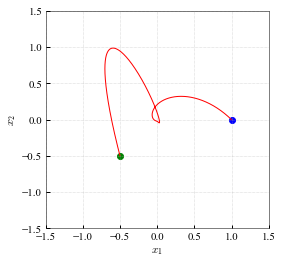

In [40]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.set_xlim(-1.5,1.5)
ax.set_ylim(-1.5,1.5)
ax.set_xticks(np.arange(-1.5, 1.51, step=0.5))
ax.set_yticks(np.arange(-1.5, 1.51, step=0.5))
ax.grid(ls = ':')
plot_set(ax, '$x_1$', '$x_2$')

u=np.array(list(map(lambda tau:reach(0,x0,tf,xf,tau), trange)))  # 理論式
_, _, x = lsim(sys, U=u, X0=x0, T=trange)    
ax.plot(x[:,0], x[:,1], lw=1, color='r',)     #　シミュレーション結果
ax.scatter(x0[0],x0[1],c='b')
ax.scatter(xf[0],xf[1],c='g')

if (is_savefig):
    fig.savefig(figpath+"ans/ch4_1_phase_portrait.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

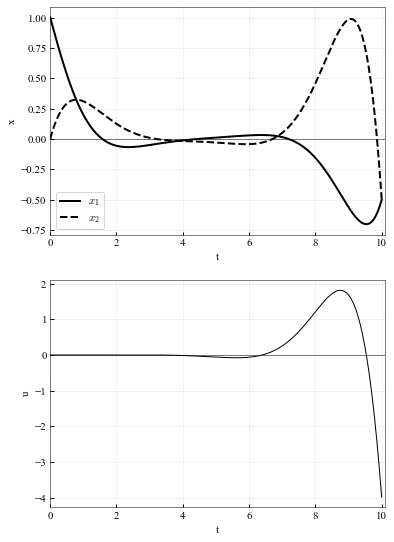

In [41]:
fig, ax = plt.subplots(2, 1, figsize=(6, 9.2))

u=np.array(list(map(lambda tau:reach(0,x0,tf,xf,tau), trange)))  # 理論式
_, _, x = lsim(sys, U=u, X0=x0, T=trange)     # シミュレーション
ax[0].plot(trange, x[:,0], lw=2, ls = '-',  color='k', label='$x_1$')                    
ax[0].plot(trange, x[:,1], lw=2, ls = '--', color='k', label='$x_2$')           
ax[0].axhline(0, color="k", linewidth=0.5)  
ax[0].grid(ls = ':')
plot_set(ax[0], 't', 'x', 'best')
ax[0].set_xlim(0,tf+0.1)

ax[1].plot(trange, u, lw=1, color='k')
ax[1].axhline(0, color="k", lw=0.5)  
ax[1].grid(ls = ':')
plot_set(ax[1], 't', 'u')
ax[1].set_xlim(0,tf+0.1)

if (is_savefig):
    fig.savefig(figpath+"ans/ch4_1_time_response.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

### 【３】 Kalmanの正準分解

In [42]:
import scipy

In [43]:
A = np.matrix([[0,-1,0],[1,-1,0],[1,0,-2]])
B = np.matrix([[0],[0],[1]])
C = np.matrix([1,0,0])
D = np.matrix([0])
sys = ss(A, B, C, D)
print(A)

[[ 0 -1  0]
 [ 1 -1  0]
 [ 1  0 -2]]


In [44]:
Vc=ctrb(A,B)
print(Vc)
np.linalg.matrix_rank(Vc)

[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 1. -2.  4.]]


1

In [45]:
Tc = scipy.linalg.orth(Vc)  # Image Vcの基底
print(Tc)

[[ 0.]
 [ 0.]
 [-1.]]


In [46]:
Vo=obsv(A,C)
print(Vo)
np.linalg.matrix_rank(Vo)

[[ 1.  0.  0.]
 [ 0. -1.  0.]
 [-1.  1.  0.]]


2

In [47]:
Tno = scipy.linalg.null_space(Vo) # Ker Voの基底
print(Tno)

[[0.]
 [0.]
 [1.]]


この例では$T_c$と$T_{no}$は（たまたま）平行である．これを補う基底として以下を選ぶ．

In [48]:
T_comp = np.matrix([[1,0,0],[0,1,0]]).transpose()
print(T_comp)

[[1 0]
 [0 1]
 [0 0]]


In [49]:
T=inv(np.block([Tno,T_comp]))
print(T)

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]


$T$を用いて等価変換

In [50]:
Abar = T*A*inv(T)
print(Abar)

[[-2.  1.  0.]
 [ 0.  0. -1.]
 [ 0.  1. -1.]]


In [51]:
Bbar=T*B
print(Bbar)

[[1.]
 [0.]
 [0.]]


In [52]:
Cbar=C*inv(T)
print(Cbar)

[[0. 1. 0.]]


### 【５】伝達関数への変換，等価変換

#### (1) 状態方程式から伝達関数への変換

In [53]:
A = np.array([[-2,1],[2,-3]])
B = np.array([[0],[1]])
C = np.array([1,1])
D = np.array([0])
sys = ss(A, B, C, D)

In [54]:
P=ss2tf(sys)
P

TransferFunction(array([1., 3.]), array([1., 5., 4.]))

#### (2) 行列$T$による座標変換

In [55]:
T=np.array([[1,0],[-2,1]])

In [56]:
Abar=T@A@inv(T)
Abar

array([[ 0.,  1.],
       [-4., -5.]])

In [57]:
Bbar=T@B
Bbar

array([[0],
       [1]])

In [58]:
Cbar=C@inv(T)
Cbar

array([3., 1.])

#### (3)変換後の伝達関数

In [59]:
sys_bar = ss(Abar,Bbar,Cbar,D)

In [60]:
Pbar=ss2tf(sys_bar)
Pbar

TransferFunction(array([1., 3.]), array([1., 5., 4.]))